# Определение возраста покупателей

**Описание проекта**

<p>Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:</p>
<p>1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.</p>
<p>2. Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.</p>

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def show_info(df):
    print('Количество строк выборки составляет:',df.shape[0],'\n')
    display('Первые пять строк', df.head())
    print('Общая информация о данных\n')
    print(df.info())
    display('Описание',df.describe().T)
    print('Количество явных дубликатов составляет',df.duplicated().sum())

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
show_info(labels)

Количество строк выборки составляет: 7591 



'Первые пять строк'

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


'Описание'

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


Количество явных дубликатов составляет 0


данные содержат 7591 фото.

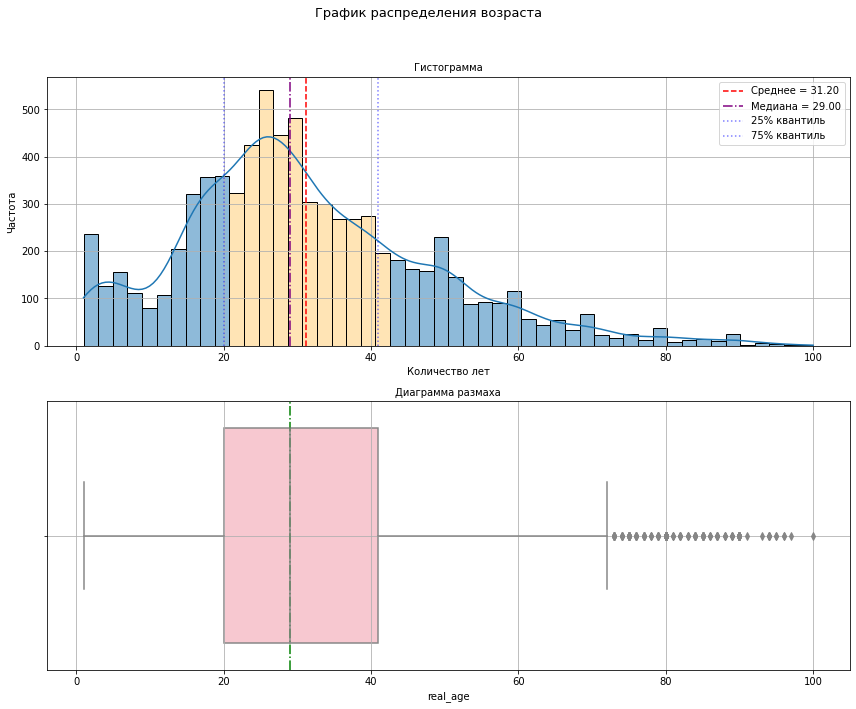

In [5]:
mean = labels['real_age'].mean()
median = labels['real_age'].median()
q25 = labels['real_age'].quantile(0.25)
q75 = labels['real_age'].quantile(0.75)

fig, ax = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle(f"График распределения возраста", fontsize=13)

# Гистограмма
hist = sns.histplot(labels['real_age'], bins=50, kde=True, ax=ax[0])
ax[0].set_title('Гистограмма', fontsize=10)
ax[0].set_xlabel("Количество лет")
ax[0].set_ylabel('Частота')
ax[0].grid(True)

# Закрашиваем область между квантилями
for patch in hist.patches:
    if q25 <= patch.get_x() <= q75:
        patch.set_facecolor('moccasin')

ax[0].axvline(mean, color='red', linestyle='--', label=f'Среднее = {mean:.2f}')
ax[0].axvline(median, color='purple', linestyle='-.', label=f'Медиана = {median:.2f}')
ax[0].axvline(q25, color='blue', linestyle=':', alpha=0.5, label='25% квантиль')
ax[0].axvline(q75, color='blue', linestyle=':', alpha=0.5, label='75% квантиль')
ax[0].legend()

# Boxplot
sns.boxplot(x=labels['real_age'], ax=ax[1], color='pink')
ax[1].set_title('Диаграмма размаха', fontsize=10)
ax[1].axvline(median, color='green', linestyle='-.')
ax[1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show();

1) Визуально гистограмма показывает, что данные близки к нормальному распределению.

2) Среднее и медиана: Среднее (31.20) выше медианы (29.00), что говорит о легком правом смещении. Это из-за наличие выбросов высокого возраста, что особенно заметно на боксплоте.

3) Большая часть покупателей(~50%) в возрасте от 20 до 40 лет


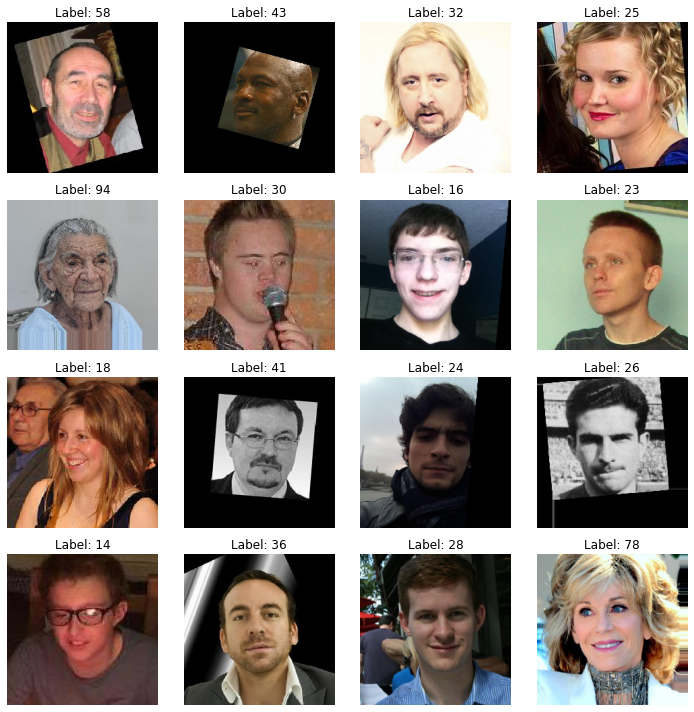

In [6]:
batch_images, batch_labels = next(train_gen_flow)
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(batch_images[i+15])
    ax.set_title(f"Label: {batch_labels[i+15]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

1) большинство изображений имеют четко изображение,разные эмоции, освещение и национальность -- данные достаточно разнообразны     
2) часть изображение аугментированы, это видно по поворотоам и небольшим размытием на некоторых фото

## Обучение модели

Архитектура модели:
* Transfer Learning: В качестве основы взята предобученная на ImageNet модель ResNet50 (без верхних слоев) 

Добавленные слои:
* GlobalAveragePooling2D() для уменьшения размерности.
    * Полносвязные слои (Dense) с активацией ReLU и BatchNormalization.
    * Финальный слой с одним нейроном (регрессия).

```python

from keras.models import Sequential
import numpy as np
from keras.layers import  GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization,Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from keras.regularizers import l2
import pandas as pd


def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        horizontal_flip=True,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.1,
    )

    return datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123,
    )


def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123,
    )

def create_model(input_shape=(224, 224, 3)):
    """Создание модели на основе ResNet50"""
    print("Модель нейросети в процессе подготовки...")
    
    weights_path = '/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    # Загрузка предобученной ResNet50 без верхних слоев
    backbone = ResNet50(
        input_shape=input_shape,
        weights=weights_path,  
        include_top=False
    )
    # for layer in backbone.layers[:100]:
    #     layer.trainable = False
    # for layer in backbone.layers[100:]:
    #     layer.trainable = True
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        # Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dense(128, activation='relu'),
        # Dropout(0.5),
        Dense(1) 
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0005),  
        loss='mse',  # MSE для регрессии
        metrics=['mae']  # MAE как метрика
    )
    
    print("Модель нейросети готова!")
    return model

def train_model(model, train_data, val_data, epochs=40, steps_per_epoch=None, validation_steps=None):
   
    model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    
    return model
```

```

2025-08-16 05:51:32.977406: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2025-08-16 05:51:33.068285: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2025-08-16 05:51:39.666712: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-08-16 05:51:40.392731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-08-16 05:51:40.392813: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-08-16 05:51:40.392845: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-16 05:51:40.756331: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-08-16 05:51:40.768164: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-08-16 05:51:40.885411: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-08-16 05:51:40.894990: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-08-16 05:51:40.895086: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-08-16 05:51:40.898092: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
Модель нейросети в процессе подготовки...
2025-08-16 05:51:41.377491: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2025-08-16 05:51:41.424860: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2025-08-16 05:51:41.426440: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4f62cb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-08-16 05:51:41.426467: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-08-16 05:51:41.601460: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x45c2fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-16 05:51:41.601502: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2025-08-16 05:51:41.603199: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-08-16 05:51:41.603249: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-08-16 05:51:41.603258: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-16 05:51:41.603283: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-08-16 05:51:41.603293: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-08-16 05:51:41.603301: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-08-16 05:51:41.603310: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-08-16 05:51:41.603317: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-08-16 05:51:41.606122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2025-08-16 05:51:41.620068: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-08-16 05:51:43.410694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-08-16 05:51:43.410757: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2025-08-16 05:51:43.410769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2025-08-16 05:51:43.414012: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-08-16 05:51:43.414058: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Модель нейросети готова!
<class 'keras.engine.sequential.Sequential'>
Epoch 1/40
2025-08-16 05:52:35.544092: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-16 05:52:37.183563: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
 - 139s - loss: 418.7607 - mae: 15.8334 - val_loss: 507.0015 - val_mae: 17.3408
Epoch 2/40
 - 84s - loss: 189.2066 - mae: 10.6041 - val_loss: 281.9799 - val_mae: 14.2165
Epoch 3/40
 - 83s - loss: 158.3437 - mae: 9.6345 - val_loss: 204.8202 - val_mae: 12.8144
Epoch 4/40
 - 84s - loss: 136.5417 - mae: 8.9209 - val_loss: 92.4518 - val_mae: 11.7667
Epoch 5/40
 - 84s - loss: 128.7029 - mae: 8.6853 - val_loss: 869.2525 - val_mae: 11.5100
Epoch 6/40
 - 84s - loss: 119.9535 - mae: 8.3736 - val_loss: 156.2972 - val_mae: 8.8187
Epoch 7/40
 - 84s - loss: 116.0410 - mae: 8.2183 - val_loss: 204.1507 - val_mae: 11.1251
Epoch 8/40
 - 83s - loss: 109.1057 - mae: 7.9954 - val_loss: 43.6924 - val_mae: 8.3601
Epoch 9/40
 - 84s - loss: 104.8736 - mae: 7.8159 - val_loss: 231.3077 - val_mae: 10.1133
Epoch 10/40
 - 84s - loss: 108.2711 - mae: 7.9431 - val_loss: 464.6949 - val_mae: 13.0401
Epoch 11/40
 - 83s - loss: 106.4149 - mae: 7.8833 - val_loss: 120.7289 - val_mae: 10.8293
Epoch 12/40
 - 83s - loss: 114.1272 - mae: 8.1348 - val_loss: 298.2072 - val_mae: 9.2984
Epoch 13/40
 - 83s - loss: 108.5712 - mae: 7.9522 - val_loss: 64.7465 - val_mae: 10.7447
Epoch 14/40
 - 84s - loss: 101.2120 - mae: 7.6189 - val_loss: 66.3751 - val_mae: 7.5628
Epoch 15/40
 - 83s - loss: 92.1939 - mae: 7.3380 - val_loss: 103.9344 - val_mae: 8.7532
Epoch 16/40
 - 83s - loss: 91.2258 - mae: 7.2950 - val_loss: 84.2461 - val_mae: 7.8197
Epoch 17/40
 - 84s - loss: 83.7064 - mae: 7.0694 - val_loss: 183.8632 - val_mae: 7.9339
Epoch 18/40
 - 83s - loss: 80.0558 - mae: 6.7791 - val_loss: 293.6172 - val_mae: 7.5948
Epoch 19/40
 - 83s - loss: 82.9647 - mae: 6.9618 - val_loss: 88.0434 - val_mae: 7.9657
Epoch 20/40
 - 83s - loss: 80.3844 - mae: 6.8284 - val_loss: 281.2224 - val_mae: 8.8015
Epoch 21/40
 - 83s - loss: 74.4569 - mae: 6.5832 - val_loss: 25.7375 - val_mae: 8.7381
Epoch 22/40
 - 83s - loss: 74.8828 - mae: 6.5252 - val_loss: 61.2066 - val_mae: 7.6275
Epoch 23/40
 - 83s - loss: 69.9999 - mae: 6.4070 - val_loss: 52.8453 - val_mae: 7.6331
Epoch 24/40
 - 84s - loss: 67.3455 - mae: 6.2487 - val_loss: 69.8021 - val_mae: 7.5460
Epoch 25/40
 - 84s - loss: 64.9677 - mae: 6.1304 - val_loss: 244.2747 - val_mae: 7.9022
Epoch 26/40
 - 84s - loss: 61.6995 - mae: 6.0099 - val_loss: 374.6970 - val_mae: 10.0721
Epoch 27/40
 - 84s - loss: 59.8070 - mae: 5.9304 - val_loss: 97.7904 - val_mae: 7.5791
Epoch 28/40
 - 84s - loss: 59.9690 - mae: 5.8953 - val_loss: 217.4491 - val_mae: 9.7187
Epoch 29/40
 - 83s - loss: 64.5314 - mae: 6.1427 - val_loss: 78.9597 - val_mae: 7.5284
Epoch 30/40
 - 83s - loss: 59.1026 - mae: 5.8752 - val_loss: 114.7969 - val_mae: 7.3581
Epoch 31/40
 - 83s - loss: 60.7440 - mae: 5.9188 - val_loss: 102.2581 - val_mae: 7.4458
Epoch 32/40
 - 84s - loss: 55.5241 - mae: 5.7327 - val_loss: 119.9596 - val_mae: 7.8448
Epoch 33/40
 - 84s - loss: 53.3223 - mae: 5.5966 - val_loss: 15.0040 - val_mae: 6.9535
Epoch 34/40
 - 84s - loss: 53.3710 - mae: 5.6248 - val_loss: 106.9556 - val_mae: 7.7079
Epoch 35/40
 - 84s - loss: 48.9773 - mae: 5.3815 - val_loss: 90.3384 - val_mae: 7.9341
Epoch 36/40
 - 85s - loss: 48.2016 - mae: 5.3552 - val_loss: 29.2457 - val_mae: 7.5177
Epoch 37/40
 - 83s - loss: 45.2306 - mae: 5.1190 - val_loss: 86.6646 - val_mae: 8.9686
Epoch 38/40
 - 83s - loss: 49.0627 - mae: 5.3882 - val_loss: 161.8053 - val_mae: 7.8318
Epoch 39/40
 - 84s - loss: 57.7532 - mae: 5.7787 - val_loss: 51.8476 - val_mae: 6.8515
Epoch 40/40
 - 84s - loss: 52.3726 - mae: 5.5294 - val_loss: 10.5891 - val_mae: 6.7964
Test MAE: 6.7964

```

## Анализ обученной модели

Итоговый MAE на валидации: 6.79 лет (<8 по заданию) за 40 эпох обучения.

**Рекомендации:**  
- Заморозить часть слоев ResNet для сохранения полезных признаков.  
- Добавить регуляризацию (Dropout, L2) для снижения переобучения.  
- Уменьшить `learning_rate` для более стабильной тонкой настройки. 
- Использовать большее кол-во эпох

**Вывод:** Модель работоспособна, но требует небольшой оптимизации для повышения точности.**